# Crossvalidation and Regularization

Peter Ralph

https://uodsci.github.io/dsci345

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15, 8)
import numpy as np
import pandas as pd
from dsci345 import pretty

rng = np.random.default_rng(123)

$$\renewcommand{\P}{\mathbb{P}} \newcommand{\E}{\mathbb{E}} \newcommand{\var}{\text{var}} \newcommand{\sd}{\text{sd}} \newcommand{\cov}{\text{cov}} \newcommand{\cor}{\text{cor}}$$
This is here so we can use `\P` and `\E` and `\var` and `\cov` and `\cor` and `\sd` in LaTeX below.

# A cautionary tale

In [2]:
import datetime
full_covid = pd.read_csv("data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")[["state", "tot_cases", "submission_date"]]
covid = full_covid.rename(columns={'submission_date': 'date', "tot_cases": "cases"})
covid.date = pd.to_datetime(covid.date)
covid = covid[covid.date < np.datetime64("2021-01-01")]
covid = covid[covid.date.dt.dayofweek == 0]
states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA',
       'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND',
       'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA',
       'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV', 'WY']
covid = covid[np.isin(covid.state, states)]
covid = covid.pivot(index="date", columns="state")
covid = covid.diff()[1:]
covid.columns = [x[1] for x in covid.columns]

 Here are weekly COVID case counts across the US states plus DC, PR, and GU for 2020,
 a 48 x 53 matrix:

In [3]:
covid

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
date,,,,,,,,,,,,,,,,,,,,,
2020-02-03,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-17,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-24,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-02,0.0,0.0,0.0,0.0,14.0,1.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,5.0,94.0,11.0,1.0,2.0,0.0,16.0,...,0.0,0.0,12.0,1.0,2.0,1.0,153.0,1.0,0.0,0.0
2020-03-16,1.0,36.0,17.0,12.0,259.0,135.0,40.0,20.0,7.0,138.0,...,10.0,10.0,44.0,28.0,49.0,7.0,656.0,52.0,0.0,3.0
2020-03-23,37.0,188.0,180.0,235.0,1341.0,582.0,374.0,115.0,58.0,1065.0,...,18.0,495.0,231.0,251.0,203.0,60.0,1212.0,363.0,20.0,23.0
2020-03-30,80.0,770.0,307.0,904.0,4030.0,1890.0,2156.0,358.0,245.0,4408.0,...,73.0,1037.0,2587.0,526.0,766.0,168.0,2553.0,805.0,125.0,69.0


**Question:** Can we predict, say, Oregon's case counts
using the other states?

In [22]:
from sklearn.linear_model import LinearRegression as lm
other_states = covid.loc[:,covid.columns != "OR"]
obs_OR = covid.loc[:,"OR"]
OR_fit = lm().fit(other_states, obs_OR)
est_OR = OR_fit.predict(other_states)
print(f"mean absolute error: {np.mean(np.abs(est_OR - obs_OR))}")

mean absolute error: 2.3438757879024052e-11


Gee, we can predict the case counts *perfectly*?
Does that seem very likely? What's going on?

Let's think about what we're trying to do here.
We're trying to find coefficients $b_1, \ldots, b_k$
so that the the linear combination of the columns of $X$
$$  \hat y = b_1 X_{\cdot 1} + \cdots + b_k X_{\cdot k} $$
is as close to $y$ as possible.

Well, when is it possible to find $b$ so that $\hat y = y$?
It is possible if $y$ is in the column space of $X$.

Recall that $X$ is an $n \times k$ matrix.
If $n \le k$ then the columns of $X$ span then *entire* space $\mathbb{R}^n$
(unless for instance some columns are identical).

*Takeaway:* if you have more variables than observations
(the problem is *singular* and)
it is always possible to *exactly* predict the response.

*However,* these predictions are unlikely to be *generalizable*.

# Crossvalidation

How to tell how good your model is?

*See how well it predicts "new" data.*

To do $k$-fold crossvalidation:

1. Split your dataset into $k$ chunks (these should be independent!), and
2. for each chunk in turn, put it aside for "testing"
    and train your model on the remaining $k-1$ chunks.
3. Compare "test error" to "training error".

Predictions for data used to fit the model ("training error")
should not be much further off than for data held out ("test error").

This can be used either as an indication of *overfitting*
or to compare different models to each other.

# Crossvalidation set-up

Here's a pretty 'easy' prediction problem:

In [23]:
n = 100
x = np.array([
    rng.uniform(low=0, high=10, size=n),
    rng.normal(size=n),
]).T
y = 2.5 + 1.5 * x[:,0] - 4.2 * x[:,1] + rng.normal(size=n)

Scatter plots of $y$ against $x0$ and $x1$ show increasing and decreasing trends,
with scatter about the trend of plus/minus 5 or 10.

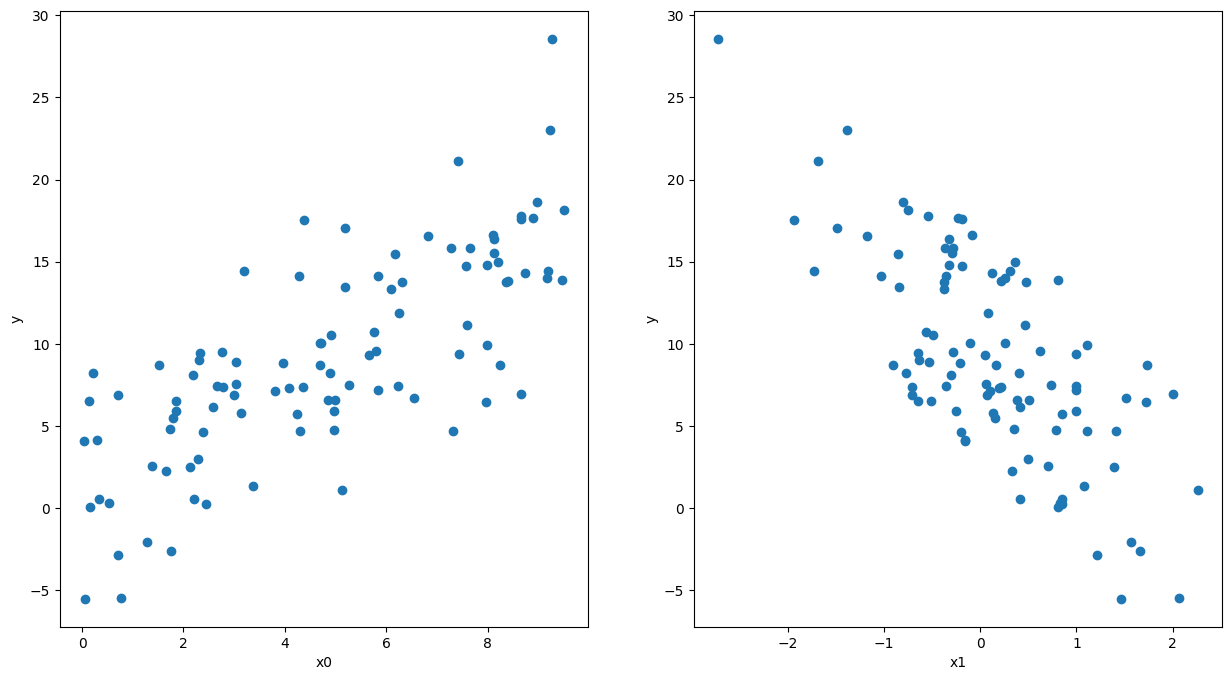

In [7]:
# plot 1
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.scatter(x[:,0], y); ax0.set_xlabel("x0"); ax0.set_ylabel("y")
ax1.scatter(x[:,1], y); ax1.set_xlabel("x1"); ax1.set_ylabel("y");

Let's (a) fit a linear model
and (b) do crossvalidation to look for evidence of overfitting.

In [6]:
def rmse(X, y, model):
    # root mean squared error, comparing y
    # to the value predicted by `model` using `x`
    yhat = model.predict(X)
    resids = y - yhat
    return np.sqrt(np.mean(resids ** 2))

def kfold(k, X, y, model):
    # x: matrix, y: vector with same number of entries as rows of x
    # model is something with .fit() and .predict() methods
    n  = len(y)
    folds = np.repeat(np.arange(k), np.ceil(n / k))[:n]
    rng.shuffle(folds)
    test_rmse = []
    train_rmse = []
    for ik in range(k):
        test_X = X[folds == ik]
        test_y = y[folds == ik]
        train_X = X[folds != ik]
        train_y = y[folds != ik]
        model.fit(train_X, train_y)
        test_rmse.append(rmse(test_X, test_y, model))
        train_rmse.append(rmse(train_X, train_y, model))
    return pd.DataFrame({
        "test" : test_rmse,
        "train" : train_rmse,
    })

crossval = kfold(5, x, y, lm())
crossval

,test,train
0,1.002842,1.102181
1,1.280119,1.030386
2,1.342009,1.017593
3,1.042074,1.093432
4,0.939767,1.114522


*Conclusion:* test error was higher than training error,
but not much; there is (unsurprisingly) no evidence of (serious) overfitting.

# When you've got too many variables

We're going to *add more variables* -
these will be *independent* of everything else, so they should *not*
give us meaningful predictive power for $y$.
However, by chance each is a little correlated with $y$.

In [7]:
crossval = pd.DataFrame()
for new_vars in np.linspace(0, 80, 9):
    new_x = rng.normal(size=(n, int(new_vars)))
    X = np.column_stack([x, new_x])
    xval = kfold(5, X, y, lm())
    xval["new_vars"] = int(new_vars)
    crossval = pd.concat([crossval, xval])

In [9]:
crossval.groupby("new_vars").agg("mean")

,test,train
new_vars,,
0,1.110210,1.073274e+00
10,1.131773,9.814478e-01
20,1.195595,8.676728e-01
30,1.435734,8.497807e-01
40,1.643874,7.860045e-01
50,2.220248,6.495097e-01
60,2.449532,4.561749e-01
70,3.008827,2.462803e-01
80,5.477928,1.176357e-14


Both 'test' and 'train' error start at 1, but as the number of variables increases,
the 'test' error goes up (steeply above about 60 variables),
while the 'train' error goes down (near zero by 80).

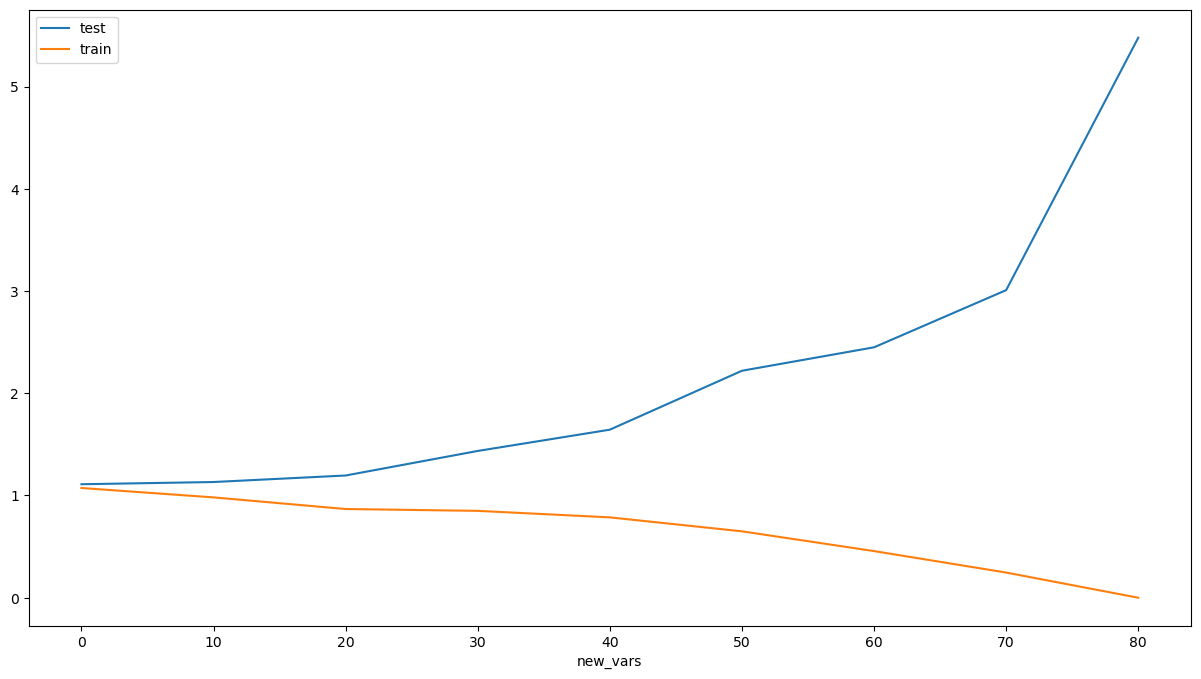

In [8]:
crossval.groupby("new_vars").agg("mean").plot();

*Conclusion:* as the number of variables increases, the training error decreases - even though we *know* there's no new information being added!
The model is overfitting, which leads to increasing test (i.e., out-of-sample) error - the thing we generally care about.

# Regularization

Recall that, somewhat mysteriously,
scikit-learn's method to fit a Binomial GLM with a logistic link function
[has a "penalty" option](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
What's that?

Well, method finds $b$ to maximize the likelihood under the following model:
$$ Y_i \sim \text{Binomial}(N, p(X_i \cdot b)), $$
where $p(\cdot)$ is the logistic function.
The terms in the log-likelihood that depend on $b$ are
$$
    \sum_{i=1}^n \left\{
        Y_i \log(p(X_i \cdot b)) + (N_i - Y_i) \log(1 - p(X_i \cdot b))
    \right\} .
$$

The problem we had above
was that the variables that didn't matter
had small but nonzero estimated parameters;
and there were so many of them,
that together they added up to something big.

*Solution:* "encourage" them to be small.

So, with a "penalty" the method instead maximizes the log-likelihood **minus**
a "regularization" term that does the "encouraging".
Options:
$$\begin{aligned}
  \sum_j |b_j| \qquad & \text{"L1" or "$\ell_1$" or "lasso"}\\
  \sum_j b_j^2 \qquad & \text{"L2" or "$\ell_2$" or "ridge" or "Tikhonov"}
\end{aligned}$$

```
sklearn.linear_model.LogisticRegression(penalty="l1")
```
therefore finds the $b$ that maximizes
$$
    \sum_{i=1}^n \left\{
        Y_i \log(p(X_i \cdot b)) + (N_i - Y_i) \log(1 - p(X_i \cdot b))
    \right\}  - \sum_j |b_j| .
$$

# The Lasso

Let's try out this scheme on our example data, using [the Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html),
which fits a standard least-squares linear model but with a L1 penalty, minimizing
$$ \sum_i (y_i - X_i \cdot b)^2 + \alpha \sum_j |b_j| . $$

In [36]:
from sklearn.linear_model import Lasso

ridge_crossval = pd.DataFrame()
for new_vars in np.linspace(0, 80, 9):
    new_x = rng.normal(size=(len(y), int(new_vars)))
    X = np.column_stack([x, new_x]) 
    xval = kfold(5, X, y, Lasso(alpha=0.3))
    xval["new_vars"] = int(new_vars)
    ridge_crossval = pd.concat([ridge_crossval, xval])

ridge_crossval.groupby("new_vars").agg("mean")

,test,train
new_vars,,
0,1.184693,1.141430
10,1.172188,1.140055
20,1.162122,1.142433
30,1.188115,1.132634
40,1.179188,1.134871
50,1.156657,1.134801
60,1.161385,1.075362
70,1.173129,1.129902
80,1.202115,1.096424


Now, both 'test' and 'train' curves stay roughly flat (with 'test' slightly above 'train').

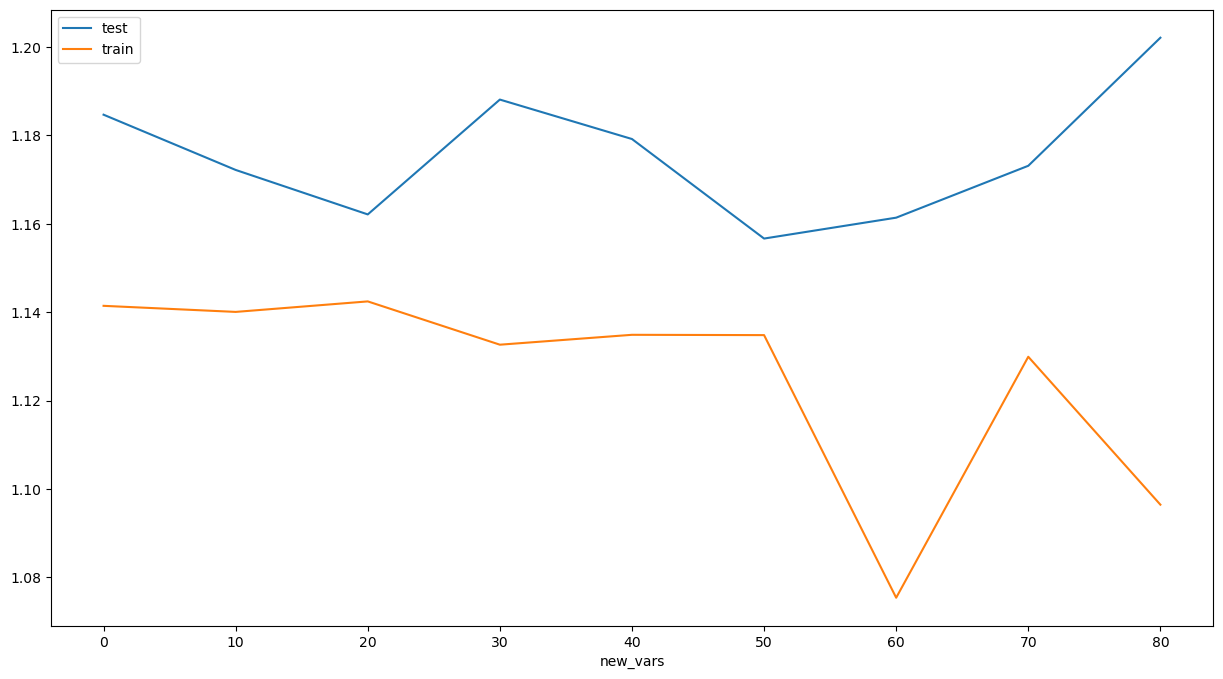

In [37]:
ridge_crossval.groupby("new_vars").agg("mean").plot();

Test error is still consistently higher than training error - as we'd expect - but only slightly.

# Exercise

Let's use *crossvalidation* to choose the *strength of regularization*
(i.e., the $\alpha$ parameter in the lasso).

We'll apply it to the `covid` data above.